In [1]:
from matplotlib.pyplot import axis, figure, imshow, legend
from matplotlib.pyplot import scatter, show, subplot, title
import numpy as np

# Numpy version >= 1.17.4

points_filename = r"test_points.txt"

images_filename = r"mnist-test"
labels_filename = r"mnist-test-labels"

# Helper functions:
def load_mnist_images(filename, dtype='uint8'):
    with open(filename, 'rb') as f:
        f.read(4)
        n_samples = int.from_bytes(f.read(4), byteorder='big')
        n_rows = int.from_bytes(f.read(4), byteorder='big')
        n_cols = int.from_bytes(f.read(4), byteorder='big')
        images = np.fromfile(f, dtype=np.uint8)

    images = images.reshape((n_samples, n_rows, n_cols))
    images = np.ascontiguousarray(images, dtype=dtype)
    return images


def load_mnist_labels(filename, dtype='uint8'):
    labels = np.fromfile(filename, dtype=np.uint8, offset=8)
    return np.ascontiguousarray(labels, dtype=dtype)


def plot_cluster(dataset, k, cluster_idx, labels=None):
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']
    hatches = ['o', 'x', '+', '*', '.', '-', 'O', '|']
    n_samples, dim = dataset.shape
    assert dim == 2 and k <= len(colors), 'Too many clusters.'

    handles = []
    for i in range(k):
        selected = cluster_idx == i
        x = dataset[selected, 0]
        y = dataset[selected, 1]
        handles.append(scatter(x, y, marker=hatches[i], color=colors[i]))

    if labels is not None:
        assert len(labels) == len(handles)
        legend(handles, labels)

        
def pca(dataset, topk):
    n_samples, n_dims = dataset.shape

    dataset -= np.mean(dataset, axis=0)
    covariance = dataset.T @ dataset / (n_samples - 1)
    eig_vals, eig = np.linalg.eig(covariance)

    topk_idx = np.argsort(eig_vals, kind='stable')[::-1][:topk]
    topk_eigs = eig[:, topk_idx]
    reconstructed = dataset @ topk_eigs
    return reconstructed

`raw_data` has size: (2163, 784)


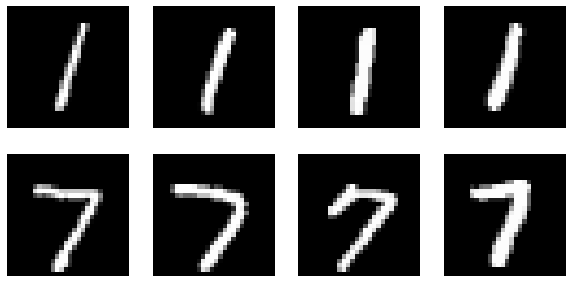

In [2]:
# load data
raw_images = load_mnist_images(images_filename, dtype='float32')
raw_labels = load_mnist_labels(labels_filename, dtype='uint8')

a_img = raw_images[raw_labels == 1]  # Handwritten number ‘1’
b_img = raw_images[raw_labels == 7]  # Handwritten number ‘7’
raw_data = np.concatenate([a_img, b_img]).reshape((-1, 784))

a_index = range(len(a_img))
b_index = range(len(a_img), len(raw_data))

print(f'`raw_data` has size: {raw_data.shape}')

figure(figsize=(10, 5))
subplot(2, 4, 1), axis('off'), imshow(a_img[0, ...], cmap='gray')
subplot(2, 4, 2), axis('off'), imshow(a_img[1, ...], cmap='gray')
subplot(2, 4, 3), axis('off'), imshow(a_img[-2, ...], cmap='gray')
subplot(2, 4, 4), axis('off'), imshow(a_img[-1, ...], cmap='gray')

subplot(2, 4, 5), axis('off'), imshow(b_img[0, ...], cmap='gray')
subplot(2, 4, 6), axis('off'), imshow(b_img[1, ...], cmap='gray')
subplot(2, 4, 7), axis('off'), imshow(b_img[-2, ...], cmap='gray')
subplot(2, 4, 8), axis('off'), imshow(b_img[-1, ...], cmap='gray')
show()

Reduced `dataset` has size: (2163, 2)


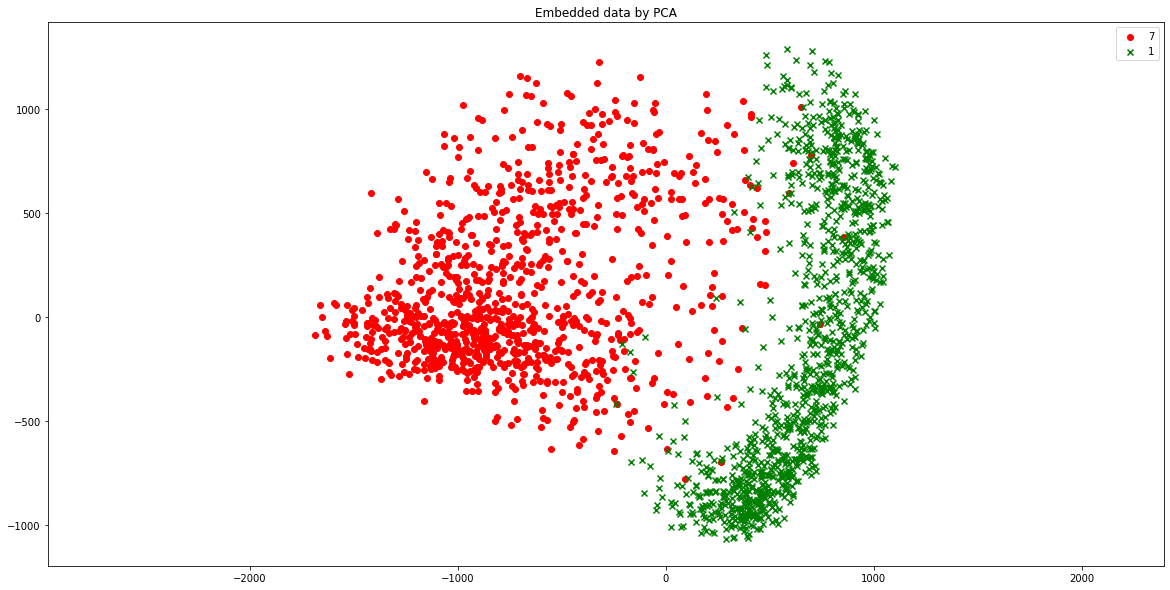

In [3]:
# reduce dimensions 784 to 2
K = 2
dataset = pca(raw_data, K)

print(f'Reduced `dataset` has size: {dataset.shape}')
figure(figsize=(20, 10))
axis('equal')
title('Embedded data by PCA')
b_out = dataset[b_index, :]
a_out = dataset[a_index, :]
p2 = scatter(b_out[:, 0], b_out[:, 1], c='r', marker='o')
p1 = scatter(a_out[:, 0], a_out[:, 1], c='g', marker='x')
legend([p2, p1], ['7', '1'])
show()

In [4]:
# ================= k-means =================
# step 1:
n_samples, dim = dataset.shape
centroids = np.zeros((K, dim), dtype='float32')
cluster_idx = np.zeros(n_samples, dtype=np.intp)
sample_dist = np.zeros(n_samples, dtype='float32')

tmp = np.empty((n_samples, K, dim), dtype='float32')

print(f'1. `centroids` has size of {centroids.shape}.')
print(f'2. `cluster_idx` has size of {cluster_idx.shape}.')
print(f'3. `sample_dist` has size of {sample_dist.shape}.')
print(f'4. `tmp` has size of {tmp.shape}.')

1. `centroids` has size of (2, 2).
2. `cluster_idx` has size of (2163,).
3. `sample_dist` has size of (2163,).
4. `tmp` has size of (2163, 2, 2).


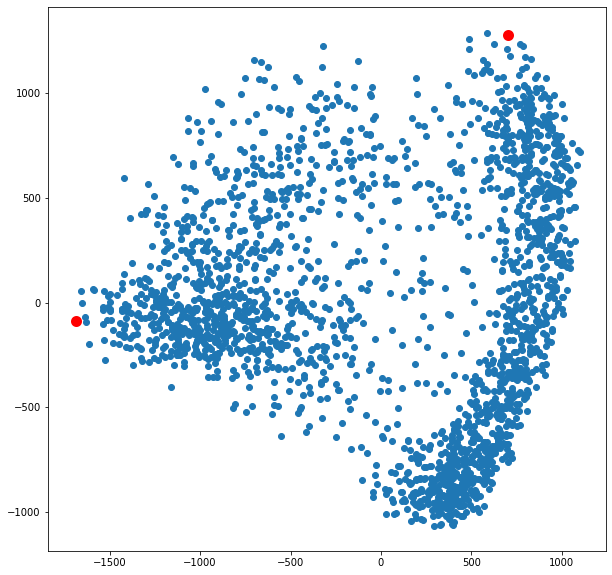

In [5]:
# step 2: use k-means++ method to initialize centroids.
cdist = np.zeros((n_samples, K), dtype='float32')
for i in range(K):
    np.subtract(dataset[:, None, :], centroids, out=tmp)
    np.square(tmp, out=tmp)
    np.sum(tmp, axis=-1, out=cdist)

    max_idx = np.argmax(np.min(cdist, axis=-1))
    centroids[i, :] = dataset[max_idx, :]

figure(figsize=(10, 10))
scatter(dataset[:, 0], dataset[:, 1])
scatter(centroids[:, 0], centroids[:, 1], color='r', linewidths='5')
show()

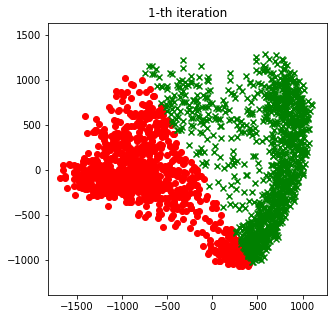

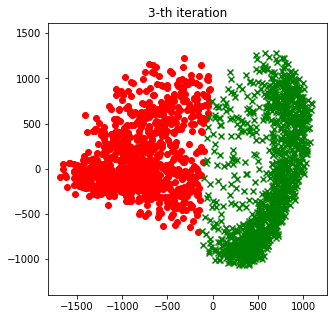

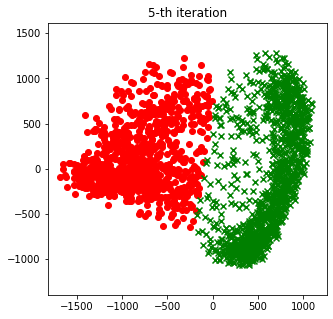

In [6]:
# step 3: computing distances and updating centroids
max_iters = 20
dist = np.zeros((n_samples, K), dtype='float32')
for i in range(max_iters):
    # compute distance
    np.subtract(dataset[:, None, :], centroids, out=tmp)
    np.square(tmp, out=tmp)
    np.sum(tmp, axis=-1, out=dist)

    min_idx = np.argmin(dist, axis=-1) # (n, k) -> (n,)
    min_dist = dist[range(n_samples), min_idx]
    changed = cluster_idx != min_idx
    if not changed.any():
        break

    # update centroids here.
    cluster_idx[changed] = min_idx[changed]
    sample_dist[changed] = min_dist[changed]
    for j in range(K):
        centroids[j, :] = np.mean(dataset[cluster_idx == j], axis=0)
        
    if i % 2 == 0:
        figure(figsize=(5, 5)), axis('equal'), title(f'{i+1}-th iteration')
        plot_cluster(dataset, K, cluster_idx)


show()

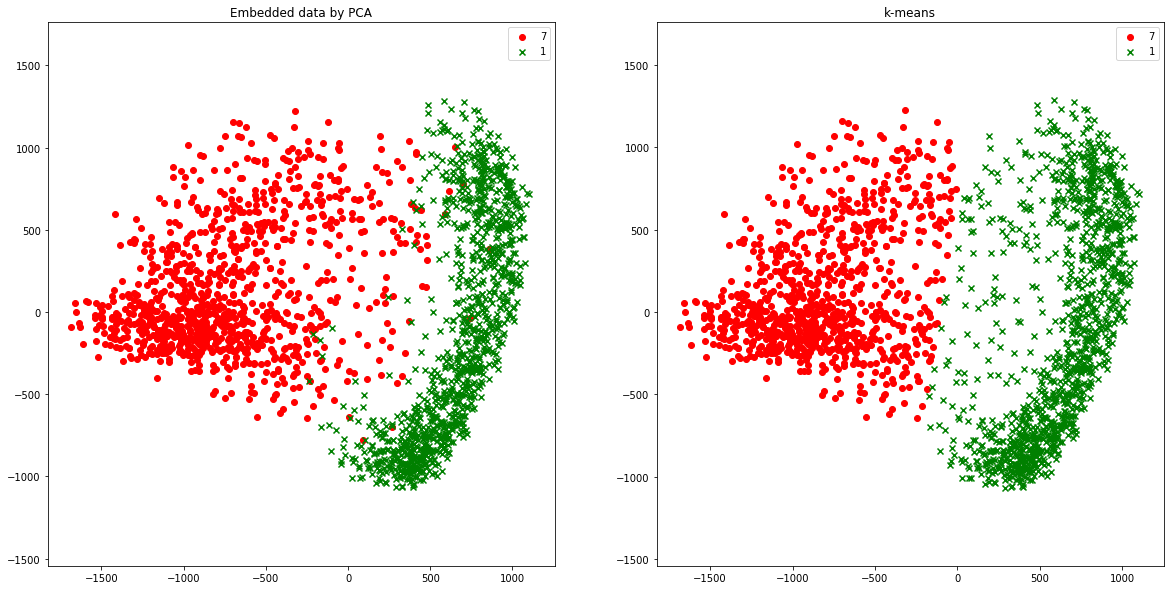

In [7]:
figure(figsize=(20, 10))
ax = subplot(1, 2, 1)
axis('equal')
ax.set_title('Embedded data by PCA')
p2 = scatter(b_out[:, 0], b_out[:, 1], c='r', marker='o')
p1 = scatter(a_out[:, 0], a_out[:, 1], c='g', marker='x')
legend([p2, p1], ['7', '1'])

ax = subplot(1, 2, 2)
axis('equal')
ax.set_title('k-means')
plot_cluster(dataset, K, cluster_idx, ['7', '1'])
show()